## FTLE Computation and Comparison with Tracers

The notebook takes SSH (Sea Surface Height) maps and tracers (SST (Sea Surface Temperature), salinity, chlorophyllis) as input. It computes FTLE (Final Time Liaponov Exponents) from the trajectories and geostrophical currents computed with Lagrangians.

The aim is to compare these results with tracers, compute their correlation and therefore evaluate the performance of various models.

In [1]:
# Import libraries

import numpy as np
import jaxparrow
import xarray as xr

### GEOSTROPHIC CURRENTS

In [23]:
xihe_ssh = xr.open_dataset('data/xihe_ssh.nc')
xihe_sst = xr.open_dataset('data/xihe_thetao.nc')

In [26]:
print(xihe_ssh.var)
print(xihe_sst.var)

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 353MB
Dimensions:     (t: 10, lat: 2041, lon: 4320, single_d: 1)
Dimensions without coordinates: t, lat, lon, single_d
Data variables:
    time        (t) int32 40B ...
    latitude    (t, lat) float32 82kB ...
    longitude   (t, lon) float32 173kB ...
    prediction  (t, single_d, lat, lon) float32 353MB ...>
<bound method DatasetAggregations.var of <xarray.Dataset> Size: 353MB
Dimensions:     (t: 10, d: 1, lat: 2041, lon: 4320)
Dimensions without coordinates: t, d, lat, lon
Data variables:
    depth       (t, d) float32 40B ...
    latitude    (t, lat) float32 82kB ...
    longitude   (t, lon) float32 173kB ...
    prediction  (t, d, lat, lon) float32 353MB ...
    time        (t) int32 40B ...
Attributes:
    history:  Wed Oct  2 08:15:36 2024: ncks -F -d d,1 predthetao.nc xihe_the...
    NCO:      netCDF Operators version 5.2.4 (Homepage = http://nco.sf.net, C...>


In [27]:
print(xihe_ssh.t)
test_map_ssh = np.squeeze(xihe_ssh.isel({'t':4})['prediction'].data)
print(test_map_ssh.shape)

<xarray.DataArray 't' (t: 10)> Size: 80B
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Dimensions without coordinates: t
(2041, 4320)


In [28]:
test_map_sst = np.squeeze(xihe_sst.isel({'t':4})['prediction'].data)
print(test_map_sst.shape)

(2041, 4320)


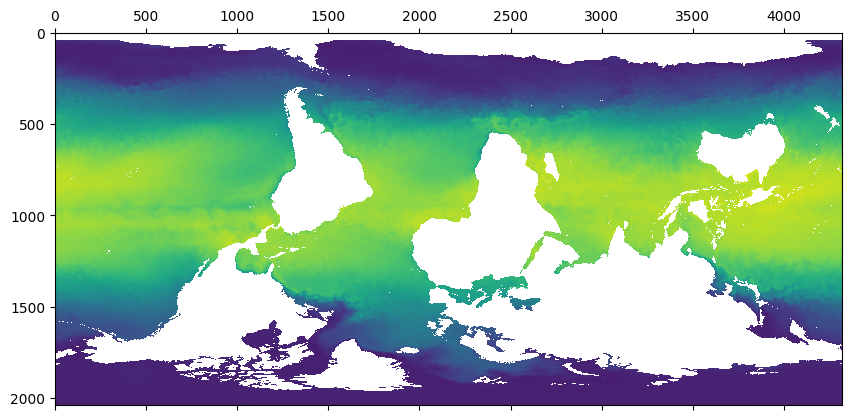

In [29]:
import matplotlib.pyplot as plt
plt.matshow(test_map_sst)

In [52]:
import jax.numpy as jnp

sst_pred = jnp.asarray(xihe_sst.prediction.data)
mask = ~(jnp.isfinite(sst_pred[0,0,:,:]))
ssh_pred = jnp.asarray(xihe_ssh.prediction.data)

In [54]:
print(ssh_pred.shape)

ssh_pred_test = ssh_pred[0,0,:,:]

print(xihe_ssh.latitude[0].size)

(10, 1, 2041, 4320)
2041


In [59]:
import jax
import jaxparrow as jpw

#vmap_geostrophy = jax.vmap(jpw.geostrophy, in_axes=(0, None, None, 0), out_axes=(0, 0, None, None, None, None))
ug_jpw_u, vg_jpw_v, lat_u, lon_u, lat_v, lon_v = jpw.geostrophy(ssh_pred[0,0,:,:], jnp.ones(xihe_ssh.latitude[0].size), jnp.ones(xihe_ssh.longitude[0].size), mask)

IndexError: Too many indices: 1-dimensional array indexed with 2 regular indices.

In [58]:
print(jnp.ones(xihe_ssh.latitude[0].size).shape)
print(jnp.ones(xihe_ssh.longitude[0].size).shape)
print(mask.shape)
ssh_pred[0,0,:,:].shape

(2041,)
(4320,)
(2041, 4320)


(2041, 4320)

In [83]:
import numpy as np

g = 9.81
Omega = 7.2921e-5
def coriolis_parameter(latitude):
    return 2 * Omega * np.sin(np.radians(latitude))

def compute_geostrophic_current(ssh, lat, lon, dlat, dlon):
    dy = dlat * 111e3
    dx = dlon * 111e3 * np.cos(np.radians(lat))
    print(dy, dx)

    ssh_y, ssh_x = np.gradient(ssh, dx, dy)

    f = coriolis_parameter(lat[:, np.newaxis])

    u = -g / f * ssh_y
    v = g / f * ssh_x

    return u, v

lat = np.squeeze(xihe_ssh.latitude.data[0])
lon = np.squeeze(xihe_ssh.longitude.data[0])
ssh = np.squeeze(xihe_ssh.prediction.data[0])

#lat = np.linspace(-10, 10, 2041) 
#lon = np.linspace(0, 20, 4320)
#ssh = np.random.rand(2041, 4320)

dlat = lat[1] - lat[0]
dlon = lon[1] - lon[0]

u, v = compute_geostrophic_current(ssh, lat, lon, dlat, dlon)

9250.282 [ 1.6061481e+03  1.6193949e+03  1.6326373e+03 ...  2.6905657e+01
  1.3453745e+01 -4.0430567e-04]


/tmp/ipykernel_85902/2590604426.py:17: RuntimeWarning: divide by zero encountered in divide
  u = -g / f * ssh_y
/tmp/ipykernel_85902/2590604426.py:18: RuntimeWarning: divide by zero encountered in divide
  v = g / f * ssh_x


(2041, 4320)


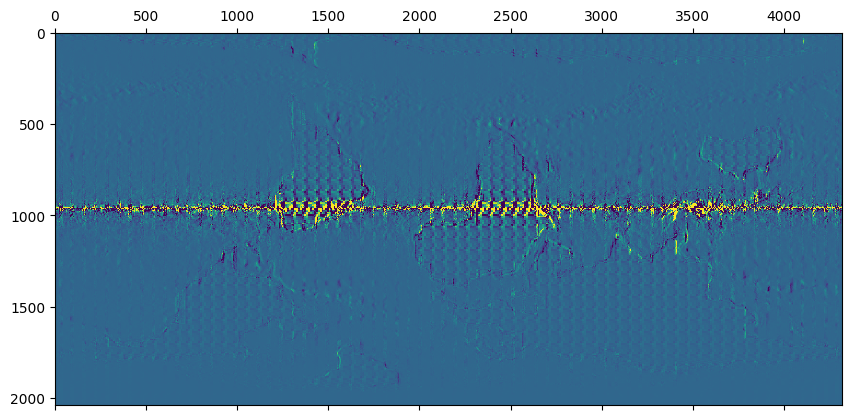

In [94]:
plt.matshow(v, vmin=-2, vmax=4)

print((u**2+v**2).shape)

In [76]:
print(xihe_ssh.latitude[0].shape)
print(xihe_ssh.longitude[0].shape)
print(np.squeeze(xihe_ssh.prediction.data[0]).shape)

(2041,)
(4320,)
(2041, 4320)


In [81]:
print(ssh.shape)
print(np.squeeze(xihe_ssh.prediction.data[0]).shape)

print(lat.shape)
print(lon.shape)
print(np.squeeze(xihe_ssh.latitude[0]))
print(np.squeeze(xihe_ssh.longitude[0]))

(2041, 4320)
(2041, 4320)
(2041,)
(4320,)
<xarray.DataArray 'latitude' (lat: 2041)> Size: 8kB
array([-80.      , -79.916664, -79.833336, ...,  89.833336,  89.916664,
        90.      ], dtype=float32)
Dimensions without coordinates: lat
<xarray.DataArray 'longitude' (lon: 4320)> Size: 17kB
[4320 values with dtype=float32]
Dimensions without coordinates: lon
